Import des librairies et dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 



df_hist = pd.read_csv("./../data/raw/weatherAUS.csv")
df_villes = pd.read_csv(""./../data/raw/villes.csv")

# Ajout des colonnes Etat et Climat
df_meteo = df_hist.merge(df_villes, right_on='Ville', left_on='Location')
df_meteo = df_meteo.drop(columns = 'Ville') 

# Découpage de la date en 3 colonnes
df_meteo['Date'] = pd.to_datetime(df_meteo['Date'], yearfirst = True)
df_meteo["Year"] = df_meteo["Date"].dt.strftime("%Y")
df_meteo["Month"] = df_meteo["Date"].dt.strftime("%m")
df_meteo["Day"] = df_meteo["Date"].dt.strftime("%d")


FileNotFoundError: [Errno 2] No such file or directory: 'villes.csv'

Distribution de la température

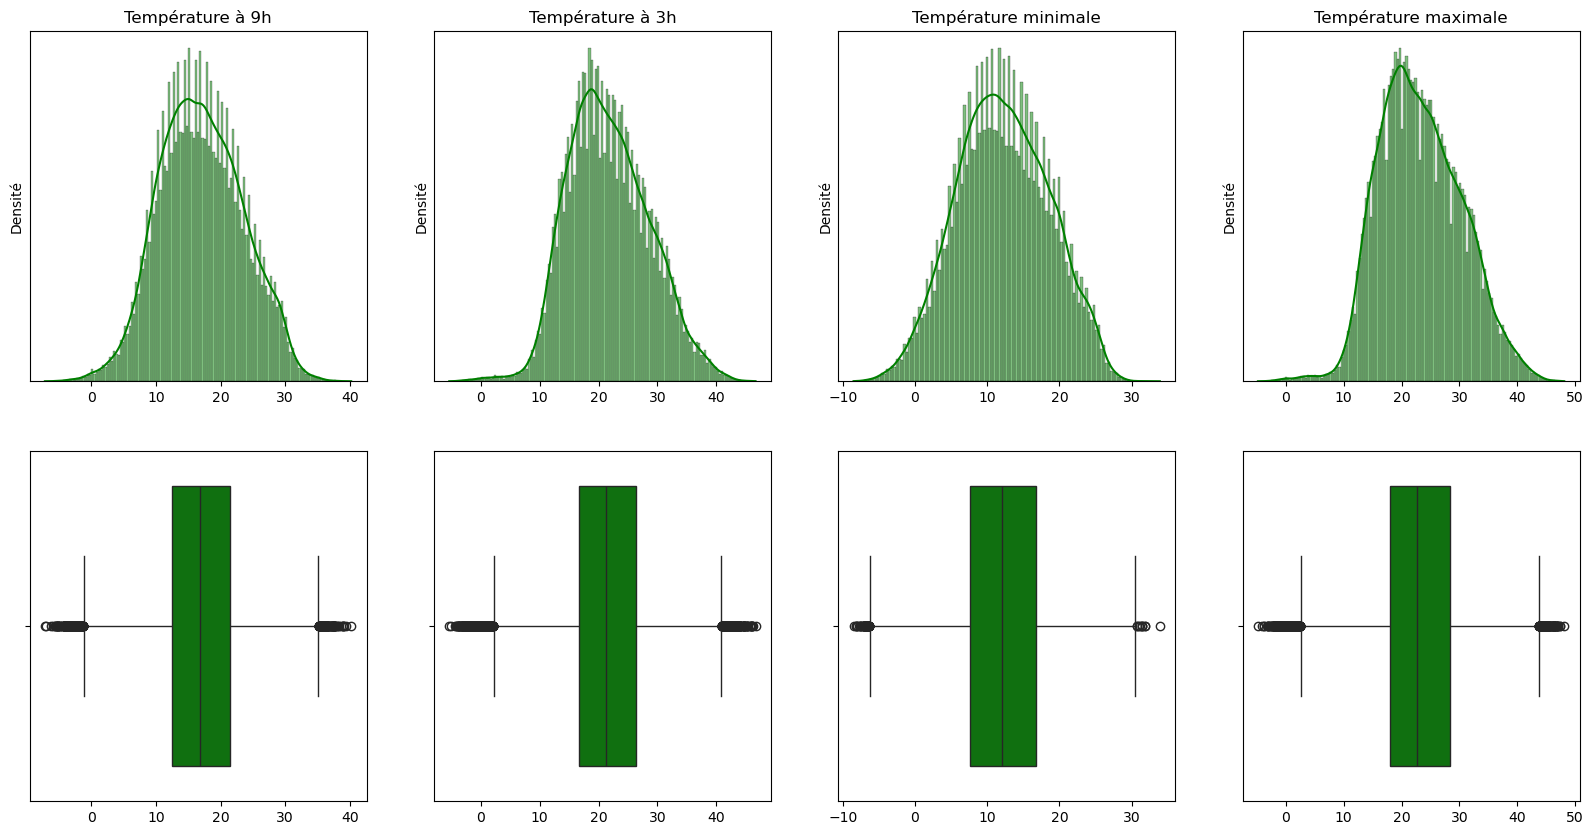

In [92]:
list_col = ["Temp9am", "Temp3pm", "MinTemp", "MaxTemp"]
list_label = ["Température à 9h", "Température à 3h", "Température minimale", "Température maximale"]
fig = plt.figure(figsize = (20, 10))
i=1
for col, label in zip(list_col, list_label) : 
    plt.subplot(2, 4, i)
    i += 1
    sns.histplot(x=df_meteo[col], kde = True, color = 'g')
    plt.title(label)
    plt.yticks([])        
    plt.ylabel("Densité")
    plt.xlabel("")

for col, label in zip(list_col, list_label) : 
    plt.subplot(2, 4, i)
    i += 1
    sns.boxplot(x=df_meteo[col], color = 'g')
    plt.title("")
    plt.ylabel("")
    plt.xlabel("")

plt.show()

Etude des différences de températures par climat

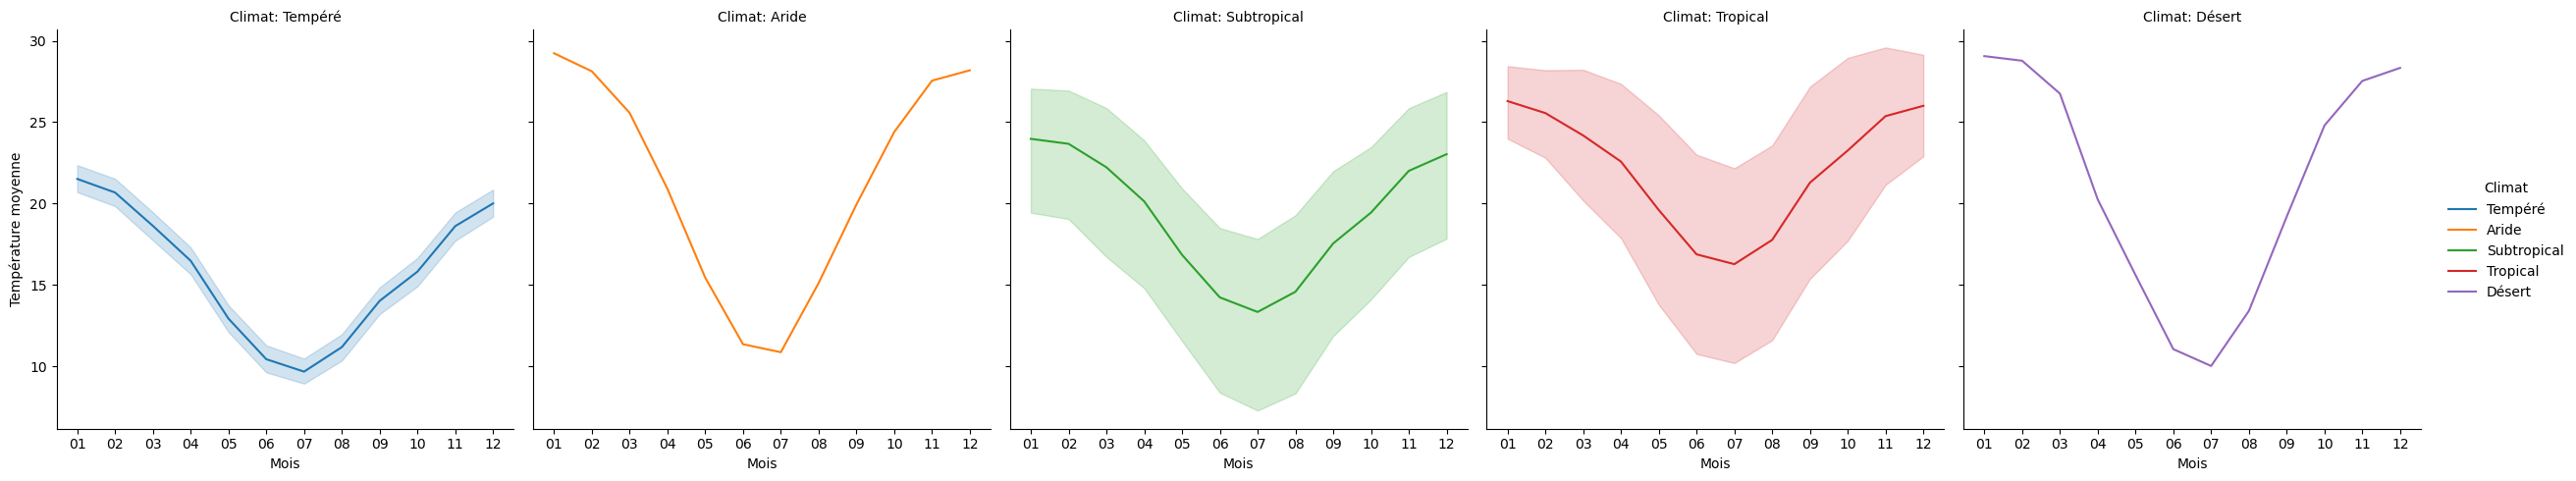

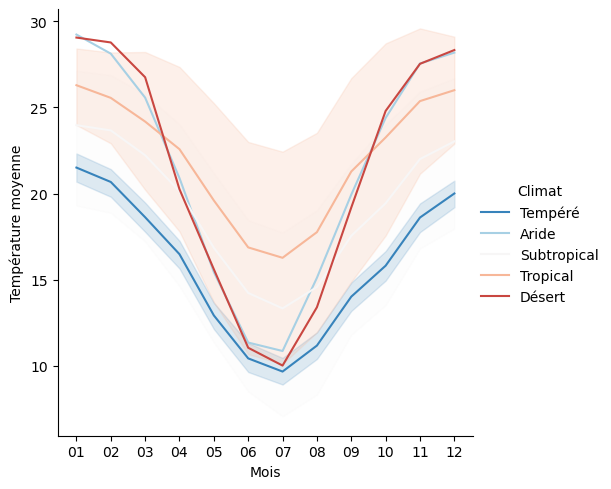

In [4]:

df_tmp = df_meteo[["Location", "Climat", "Year", "Month","Day", "Temp9am", "Temp3pm"]]
df_Temp_climat = df_tmp.groupby(by = [ "Location", "Climat","Month"]).mean("Temp9am", "Temp3pm")

g = sns.relplot(x = "Month",  y = "Temp9am", col = "Climat", hue = "Climat", kind = "line",  data = df_Temp_climat)
g.set_xlabels("Mois")
g.set_ylabels("Température moyenne")
g.set_axis_labels()
g.set_titles("Climat: {col_name}")

g = sns.relplot(x= "Month", y="Temp9am", hue="Climat", palette='RdBu_r', kind ='line' , data = df_Temp_climat)
g.set_xlabels("Mois")
g.set_ylabels("Température moyenne")



Recherche des valeurs NA à 

In [62]:
df_isna = df_meteo[["Date", "Location", "Temp9am", "Temp3pm"]].loc[(df_meteo["Temp3pm"].isna()) | (df_meteo["Temp9am"].isna()) ]
df_isna


,Date,Location,Temp9am,Temp3pm
984,2011-09-11,Albury,NaN,NaN
985,2011-09-12,Albury,NaN,NaN
986,2011-09-13,Albury,NaN,15.1
1058,2011-11-24,Albury,17.2,NaN
1059,2011-11-25,Albury,15.0,NaN
...,...,...,...,...
150514,2014-05-05,Uluru,NaN,25.0
150517,2014-05-08,Uluru,NaN,27.6
150518,2014-05-09,Uluru,NaN,27.7
150533,2014-05-24,Uluru,NaN,28.6


Complétion des données manquantes par la moyenne

In [ ]:
from datetime import datetime, timedelta

def f_get_mean_value(df, colname, date, climat, range_days = 3):
###################################################################################################################
##
## Fonction : f_get_mean_value
## Description : Fonction qui retourne la valeur moyenne d'une colonne sur l'intervalle [j-3range_days; j+range_days]
## Return : Moyenne calculée
## 
###################################################################################################################
    date_min = date - timedelta(days=range_days)
    date_max = date + timedelta(days=range_days)
    
    tmp = df.loc[(df["Date"] >= date_min) & (df["Date"] <= date_max) & (df["Climat"] == climat)]

    moyenne = np.round( tmp[colname].mean(), 1) 
    return moyenne

# df_meteo["Date"] >= '2011-01-01') & (df_meteo["Date"] <= '2011-03-30') & (df_meteo["Location"] == "BadgerysCreek") 3pm
# df_meteo["Date"] >= '2011-11-01') & (df_meteo["Date"] <= '2012-01-31') & (df_meteo["Location"] == "Canberra")]     9am
# df_meteo["Date"] >= '2009-01-01') & (df_meteo["Date"] <= '2009-02-28') & (df_meteo["Location"] == "MountGinini")]  3pm
# df_meteo["Date"] >= '2013-05-01') & (df_meteo["Date"] <= '2013-07-31') & (df_meteo["Location"] == "Ballarat")] 9am

df_hist_tmp = df_meteo[["Date", "Temp3pm"]].loc[(df_meteo["Date"] >= '2014-09-01') & (df_meteo["Date"] <= '2014-11-30') & (df_meteo["Location"] == "PearceRAAF")]

df_hist_tmp["Temp_mean"] = pd.NA

index_na = df_hist_tmp["Temp_mean"].isna()

df_hist_tmp.loc[index_na, "Temp_mean"] = df_hist_tmp[index_na].apply(lambda x: f_get_mean_value(df_meteo,"Temp3pm", x['Date'], "Tempéré"), axis=1)

df_hist_tmp["Exemple"] = 5

df_hist_tmp.to_csv("df_exemple_temp.csv")

In [77]:
import plotly.graph_objects as go



fig = go.Figure(go.Scatter( x = df_hist_tmp['Date'],
    y = df_hist_tmp['Temp3pm'], 
    name = "Température réelle"))

fig = fig.add_trace(go.Scatter( x = df_hist_tmp['Date'],
    y = df_hist_tmp['Temp_mean'],
    name = "Température moyenne"))

fig.update_layout(
    title = 'Température 3h',
    xaxis_tickformat = '%d %B %Y'
)

fig.show()